In [ ]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt # type: ignore
import cv2 # type: ignore
import seaborn as sns # type: ignore
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam, Adamax # type: ignore
from tensorflow.keras.metrics import categorical_crossentropy # type: ignore
from tensorflow.keras import regularizers # type: ignore
from tensorflow.keras.models import Model # type: ignore
import time

In [ ]:
sdir=r'F:\Papilledema\identification of pseudopapilledema dataset'
filepaths = []
labels=[] 
classlist=sorted(os.listdir(sdir) )  
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)        
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
    
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  1095   test_df length:  137   valid_df length:  137
The number of classes in the dataset is:  3
            CLASS               IMAGE COUNT 
            Normal                  623     
         Papilledema                236     
      Pseudopapilledema             236     
Normal  has the most images=  623   Papilledema  has the least images=  236
average height=  240  average width=  240 aspect ratio=  1.0


In [ ]:
from sklearn.utils import resample

# Group the data by class
groups = train_df.groupby('labels')

# Find the maximum number of samples among all classes (majority class size)
max_samples = groups.size().max()

# Upsample each class to match the size of the majority class
upsampled_dfs = []
for label, group in groups:
    upsampled_group = resample(group, replace=True, n_samples=max_samples, random_state=123)
    upsampled_dfs.append(upsampled_group)

# Combine all upsampled classes into a single DataFrame
train_df_upsampled = pd.concat(upsampled_dfs, axis=0)

# Shuffle the upsampled DataFrame
train_df = train_df_upsampled.sample(frac=1, random_state=123).reset_index(drop=True)

# Display the class distribution after upsampling
print('Class distribution after upsampling:')
print(train_df_upsampled['labels'].value_counts())
print('total:')
print(len(train_df_upsampled))

Class distribution after upsampling:
labels
Normal               623
Papilledema          623
Pseudopapilledema    623
Name: count, dtype: int64
total:
1869


In [ ]:

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Working directory and image parameters
working_dir = './'
img_size = (240, 240)  # size of augmented images
batch_size = 30

# Define augmentation function for training data
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, contrast_factor=1.4)

# Data augmentation for training
aug_gen = ImageDataGenerator(
    zoom_range=[0.9, 1.1],
    brightness_range=[0.8, 1.1],
    rotation_range=1.5,
    shear_range=1.2,
    data_format="channels_last",
    fill_mode="nearest",
    channel_shift_range=50,
    horizontal_flip=True,
    vertical_flip=True,)

# No augmentation for validation and test
free_gen = ImageDataGenerator()

# Split data: 80% for training, 20% for testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

# Further split 20% of the training data for validation (i.e., 80% of the training data will be used for actual training)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])


In [ ]:

# Create training generator with augmentations
train_gen = aug_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Create validation generator (no augmentations)
valid_gen = free_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

# Create test generator (no augmentations)
length = len(test_df)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

test_gen = free_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Extract class information
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels


# Output some useful information
print(f"Test batch size: {test_batch_size}, Test steps: {test_steps}, Number of classes: {class_count}")


Found 1196 validated image filenames belonging to 3 classes.
Found 299 validated image filenames belonging to 3 classes.
Found 374 validated image filenames belonging to 3 classes.
Test batch size: 34, Test steps: 11, Number of classes: 3


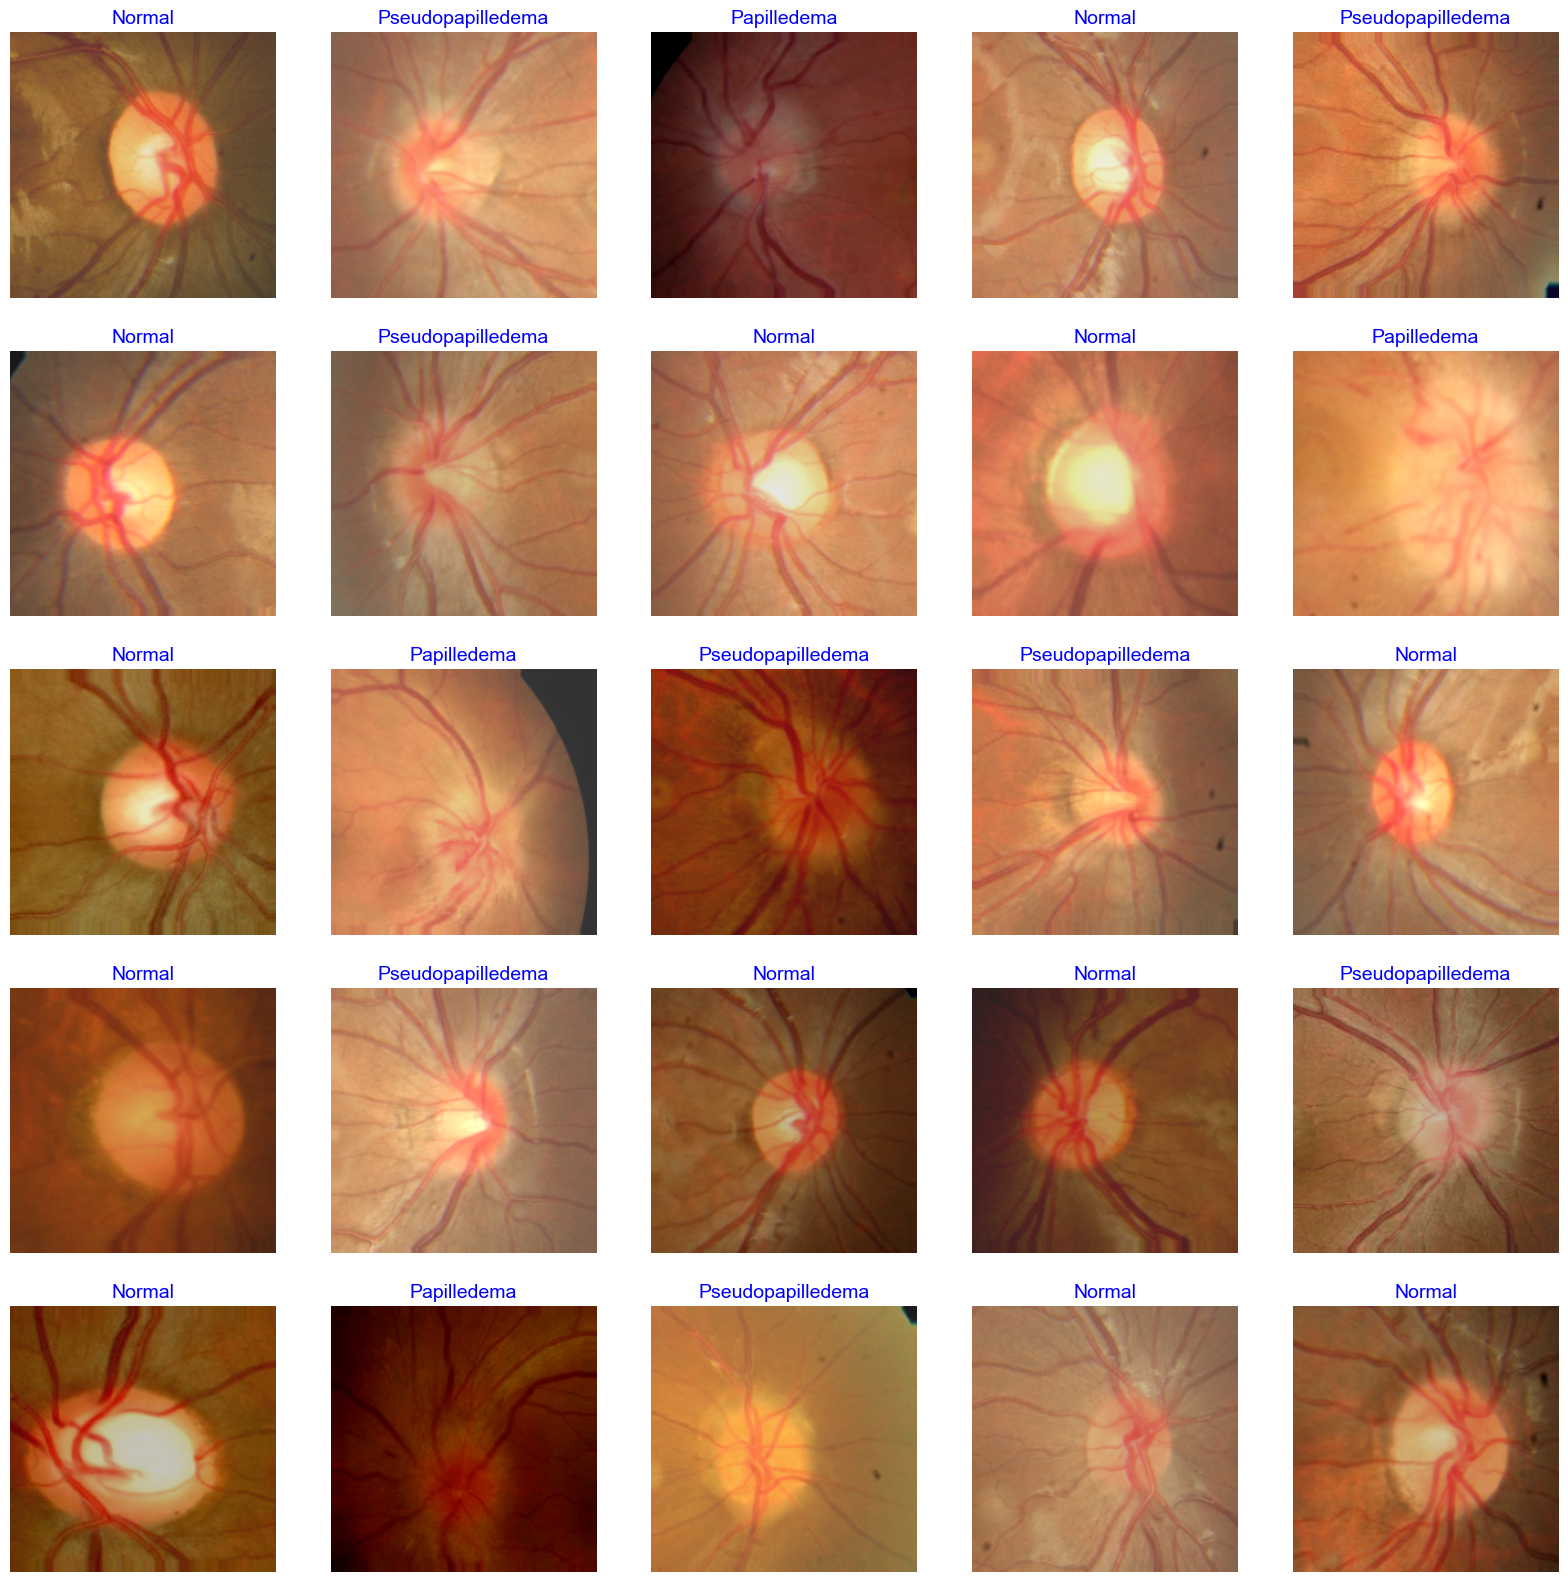

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

In [ ]:

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

# Load pre-trained InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(240, 240, 3)))
for layer in base_model.layers[:-30]:  # Freeze all but the last 30 layers
    layer.trainable = False
  # Freeze base model weights


In [ ]:

from tensorflow.keras.layers import Conv2D, Multiply, Activation

def spatial_attention(input_feature):
    # Apply a 2D convolution with a kernel size of 7x7
    attention_map = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(input_feature)
    return Multiply()([input_feature, attention_map])  # Multiply the input feature map with the attention map


In [ ]:

from tensorflow.keras.models import Model

# Get features from InceptionV3
features = base_model.output

# Apply spatial attention
attention_features = spatial_attention(features)

# Global average pooling
gap = GlobalAveragePooling2D()(attention_features)

# Fully connected layers with Dense and Dropout
fc = Dense(128, activation='relu')(gap)  # Fully connected layer with 128 neurons
dropout_1 = Dropout(0.5)(fc)  # Dropout layer to prevent overfitting

fc_2 = Dense(64, activation='relu')(dropout_1)  # Another fully connected layer
dropout_2 = Dropout(0.5)(fc_2)  # Dropout layer

# Output layer (adjust the number of output classes)
output = Dense(3, activation='softmax')(dropout_2)  # 3 output classes: Normal, Pseudo-papilledema, Papilledema
# Define the complete model
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the ReduceLROnPlateau callback
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Can also use 'accuracy' or other metrics
    factor=0.5,  # The factor by which the learning rate will be reduced
    patience=5,  # Number of epochs to wait before reducing the learning rate
    verbose=1,  # Print the learning rate change
    min_lr=1e-6  # Minimum learning rate value
)

In [ ]:
epochs=60

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, callbacks=[lr_reduction])

f:\Anaconda\envs\Papilledema\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


f:\Anaconda\envs\Papilledema\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.4034 - loss: 1.0544 - val_accuracy: 0.3344 - val_loss: 2.9416 - learning_rate: 1.0000e-04
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5804 - loss: 0.8869 - val_accuracy: 0.3411 - val_loss: 2.0126 - learning_rate: 1.0000e-04
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6566 - loss: 0.8631 - val_accuracy: 0.4247 - val_loss: 1.1995 - learning_rate: 1.0000e-04
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6517 - loss: 0.7906 - val_accuracy: 0.4983 - val_loss: 1.2625 - learning_rate: 1.0000e-04
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7424 - loss: 0.6541 - val_accuracy: 0.6555 - val_loss: 0.8487 - learning_rate: 1.0000e-04
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7442 - loss: 0.6458 - val_accuracy: 0.7525 - val_loss: 0.6166 - learning_rate: 1.0000e-04
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7606 - loss: 0.6089 - 

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

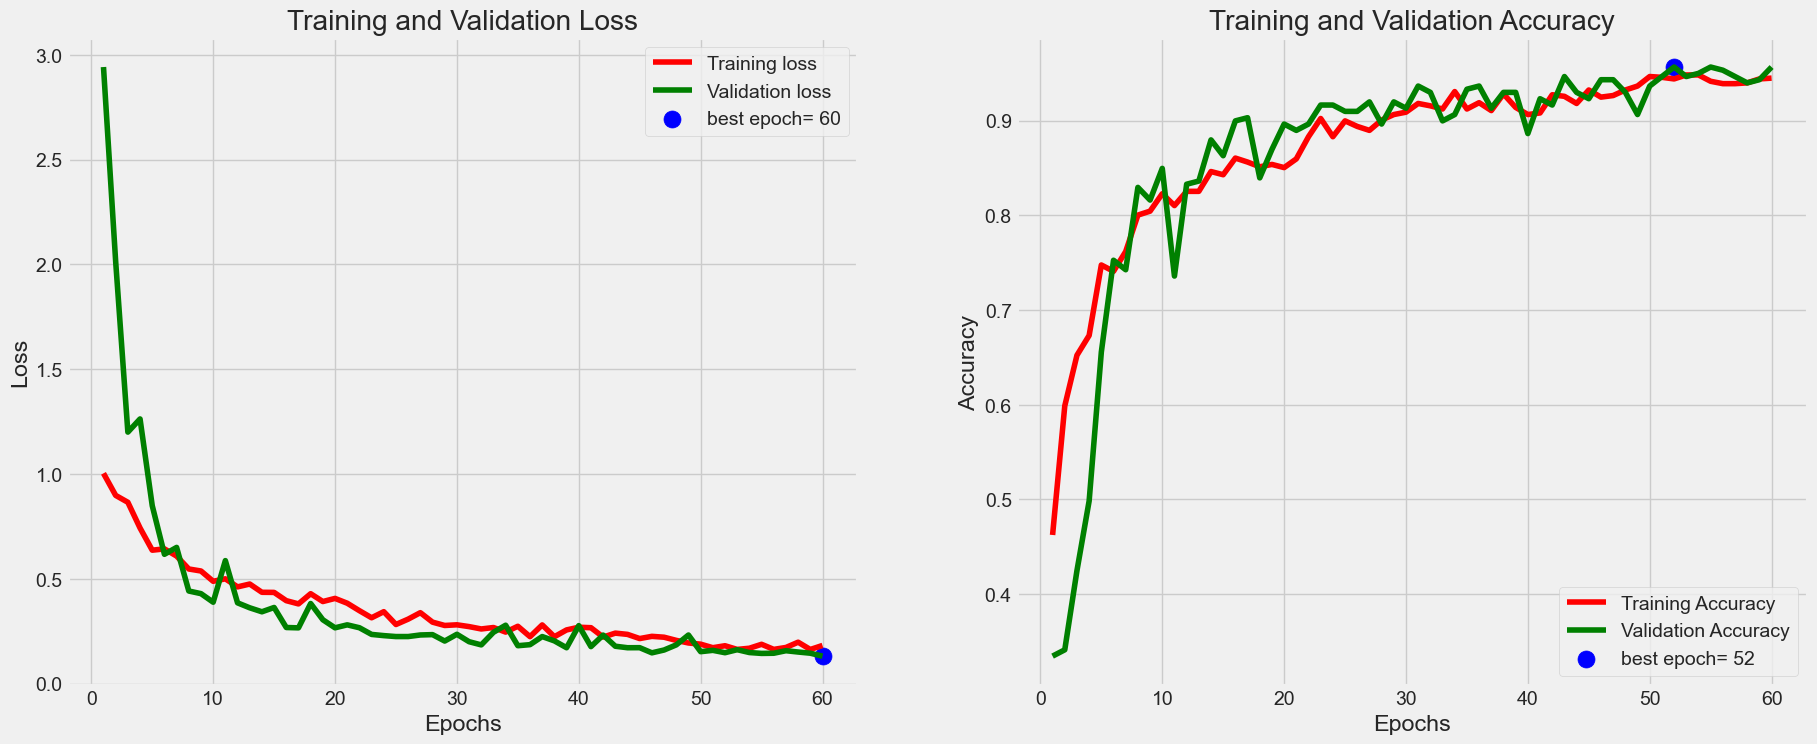

In [ ]:
tr_plot(history,0)

In [ ]:
import numpy as np
from tensorflow.keras.models import Model

# Initialize variables to track the best validation loss
best_val_loss = np.inf  # Initially, set to a very high number
best_weights = None  # Placeholder for the best weights

# After training, check the history and save the best weights based on val_loss
for epoch in range(len(history.history['val_loss'])):
    val_loss = history.history['val_loss'][epoch]
    
    # Check if this epoch's validation loss is the lowest so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.get_weights()  # Save the model weights for this epoch

# Set the model to the best weights
model.set_weights(best_weights)

# Save the model with the best weights
model.save('14thnight_spat_best_valloss.keras')

print(f"Best validation loss: {best_val_loss}")


Best validation loss: 0.1306883841753006


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the file
best_weight_model = load_model(r"F:\Papilledema\InceptionV3_SpatialAttention_Weights.keras")

# Check the loaded model summary (optional)
best_weight_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 119, 119,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 119, 119,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 119, 119,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 117, 117,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 117, 117,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 117, 117,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 117, 117,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 117, 117,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 117, 117,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 58, 58,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 58, 58,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 33,228,078 (126.76 MB)

 Trainable params: 5,527,108 (21.08 MB)

 Non-trainable params: 16,646,752 (63.50 MB)

 Optimizer params: 11,054,218 (42.17 MB)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
There were 22 errors in 374 tests for an accuracy of  94.12%


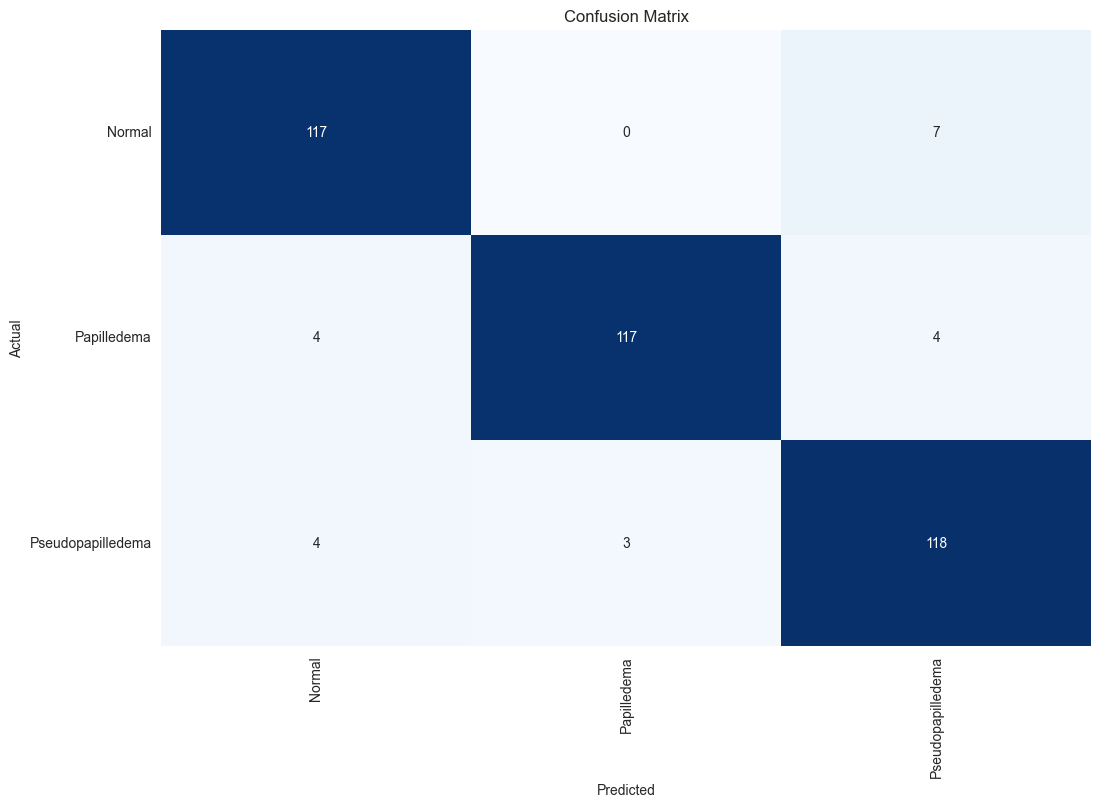


Recall (Sensitivity) for each class:
Normal: 0.9435
Papilledema: 0.9360
Pseudopapilledema: 0.9440

Specificity for each class:
Normal: 0.9680
Papilledema: 0.9880
Pseudopapilledema: 0.9558

Overall Precision: 0.9419
Overall Recall: 0.9412
Overall F1-score: 0.9413
Overall Specificity: 0.9706

Classification Report:
----------------------
                    precision    recall  f1-score   support

           Normal     0.9360    0.9435    0.9398       124
      Papilledema     0.9750    0.9360    0.9551       125
Pseudopapilledema     0.9147    0.9440    0.9291       125

         accuracy                         0.9412       374
        macro avg     0.9419    0.9412    0.9413       374
     weighted avg     0.9419    0.9412    0.9413       374



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = best_weight_model.predict(test_gen, verbose=1)
    tests = len(preds)    

    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index:  # a misclassification has occurred                                           
            errors += 1
        y_pred.append(pred_index)

    acc = (1 - errors/tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    # Compute confusion matrix
    cm = confusion_matrix(ytrue, ypred)

    if class_count <= 30:
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute Recall (Sensitivity) & Specificity per class
    recall_per_class = {}
    specificity_per_class = {}

    for i, class_label in enumerate(classes):
        TP = cm[i, i]  # True Positives
        FN = np.sum(cm[i, :]) - TP  # False Negatives
        FP = np.sum(cm[:, i]) - TP  # False Positives
        TN = np.sum(cm) - (TP + FN + FP)  # True Negatives

        recall_per_class[class_label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity_per_class[class_label] = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print recall and specificity for each class
    print("\nRecall (Sensitivity) for each class:")
    for class_label, recall in recall_per_class.items():
        print(f"{class_label}: {recall:.4f}")

    print("\nSpecificity for each class:")
    for class_label, specificity in specificity_per_class.items():
        print(f"{class_label}: {specificity:.4f}")

    # Compute overall precision, recall, F1-score, and specificity
    overall_precision = precision_score(ytrue, ypred, average="macro")
    overall_recall = recall_score(ytrue, ypred, average="macro")
    overall_f1 = f1_score(ytrue, ypred, average="macro")

    # Compute macro-averaged specificity
    overall_specificity = np.mean(list(specificity_per_class.values()))

    print(f"\nOverall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1-score: {overall_f1:.4f}")
    print(f"Overall Specificity: {overall_specificity:.4f}")

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("\nClassification Report:\n----------------------\n", clr)
    
    return errors, tests, recall_per_class, specificity_per_class, overall_precision, overall_recall, overall_f1, overall_specificity

errors, tests, recall_per_class, specificity_per_class, overall_precision, overall_recall, overall_f1, overall_specificity = predictor(test_gen, test_steps)
